# <center> Physics-guided descriptors for prediction of structural polymorphs 
## <center> (Framework to create the structures from linear combinations of distortion modes)
### <center> Bastien F. Grosso, Nicola A. Spaldin, and Aria Mansouri Tehrani
### <center> for questions or remarks: bastien.grosso@mat.ethz.ch

#### The notebook is presented in different sections where section:
    
    0) gathers the different functions needed to create and treat the structures
    1) generates a csv file with the amplitudes for all the modes according to the parameters chosen
    2) filters the lines in the csv file to respect minimum distance between atoms
    3) creates the POSCAR files for the structures in the csv file and prepare the folders for DFT calculations
    4) gathers the energies from the DFT calculations and add them into the csv file
    5) gives histograms of the energies of the different structures according to the number of modes present

## /!\ The current directory should be 'Data', the folder containing all the downloaded files if not change rootdir accordingly

In [ ]:
import os

rootdir = os.getcwd()

print(rootdir)

#rootdir = '.'

# New training set with amplitudes [-1.2;1.2] and cutoff on the max displacement and min bond

## 0) Functions

In [3]:
import numpy as np
np.set_printoptions(linewidth=np.inf)

import math 
import os 
import sys 
import re 
import shutil
from ase.io import read, write
from ase.visualize import view 
from ase.visualize.plot import plot_atoms 
from ase.build import find_optimal_cell_shape
from ase.build import stack,cut,make_supercell
from ase.atom import Atom
from ase import Atoms
from numpy.linalg import norm
#from ase.io.abinit import write_abinit
from pymatgen.io.vasp import Poscar
from pymatgen.io.cif import CifWriter
import os
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
from ase.neighborlist import neighbor_list
from ase.io import read


    
def reorder_atoms(atoms_ref, atoms_to_reorder, check_species=True): 
    atoms_to_reorder_new_indicies = [] 
    atoms_ordered = atoms_to_reorder.copy() 
    for atom in atoms_ref: 
        atoms_ref_index = atom.index 
        temp = atoms_to_reorder.copy() 
        temp.append(atom) 
        distances = temp.get_distances(-1, range(len(atoms_to_reorder)), mic=True) 
        if check_species: 
            for closest_index in np.argsort(distances): 
                if atom.symbol == atoms_to_reorder[closest_index].symbol: 
                    atoms_to_reorder_index = closest_index 
                    break 
                else: 
                    pass 
        else: 
            atoms_to_reorder_index = np.argsort(distances)[0] 
        atoms_to_reorder_new_indicies.append(atoms_to_reorder_index) 
 
    return atoms_ordered[atoms_to_reorder_new_indicies] 

## displacement vector between two structures with the same volume
def get_displacement(atoms_start,atoms_end,direct_coord=False):

 dx = atoms_end.get_positions()[:,0] - atoms_start.get_positions()[:,0]
 dy = atoms_end.get_positions()[:,1] - atoms_start.get_positions()[:,1]
 dz = atoms_end.get_positions()[:,2] - atoms_start.get_positions()[:,2]
        
 dx = dx - norm(atoms_start.cell[0])*np.round(dx/norm(atoms_start.cell[0]));
 dy = dy - norm(atoms_start.cell[1])*np.round(dy/norm(atoms_start.cell[1]));
 dz = dz - norm(atoms_start.cell[2])*np.round(dz/norm(atoms_start.cell[2]));

 if direct_coord:
  dx = dx / norm(atoms_start.cell[0])
  dy = dy / norm(atoms_start.cell[1])
  dz = dz / norm(atoms_start.cell[2])
    
 displacement = np.column_stack([dx,dy,dz])

 return displacement;

def normalize_poscar(poscar_HS_uc,poscar_dist,output_name,build_supHS = True):
    if build_supHS:
        numb_atoms_axes = get_number_atoms_axes(poscar_dist)
        supercell_matrix = np.array([[numb_atoms_axes[0],0,0],[0,numb_atoms_axes[1],0],[0,0,numb_atoms_axes[2]]])
        poscar_HS = make_supercell(poscar_HS_uc,supercell_matrix,wrap=True, tol=1e-05)
    else:
        poscar_HS = poscar_HS_uc.copy()
    

    
    poscar_dist = reorder_atoms(poscar_HS,poscar_dist)
    
    poscar_init = poscar_HS.copy()
    poscar_end = poscar_dist.copy()
    
    poscar_end.cell = poscar_HS.cell
    poscar_end.set_scaled_positions(poscar_dist.get_scaled_positions())
    
    displ = []
    displ_cart = []
    displ = get_displacement(poscar_init,poscar_end,True)
    displ_cart = get_displacement(poscar_init,poscar_end,False)

    displ = np.array(displ)
    displ_cart = np.array(displ_cart)
    print((numb_atoms_axes[0]*numb_atoms_axes[1]*numb_atoms_axes[2]))
    norm_displ = norm(displ_cart)*np.sqrt(1/(numb_atoms_axes[0]*numb_atoms_axes[1]*numb_atoms_axes[2]))
    print(norm_displ)
    poscar_init.cell = poscar_dist.cell
    poscar_init.set_scaled_positions(poscar_HS.get_scaled_positions())
    poscar_init.set_scaled_positions(poscar_init.get_scaled_positions() + displ/norm_displ)
    
    poscar_init.write(output_name,direct=True,vasp5=True)
    
    
def get_number_atoms_axes(poscar):
 atom_ref = poscar[0]

 numb_along_a = 0
 numb_along_b = 0
 numb_along_c = 0
 for atom in poscar:
    if atom.symbol == 'Fe':
        if np.abs(atom.position[1]-atom_ref.position[1]) < 1 and np.abs(atom.position[2]-atom_ref.position[2]) < 1:
            numb_along_a = numb_along_a + 1
        
        if np.abs(atom.position[0]-atom_ref.position[0]) < 1 and np.abs(atom.position[2]-atom_ref.position[2]) < 1:
            numb_along_b = numb_along_b + 1
        
        if np.abs(atom.position[0]-atom_ref.position[0]) < 1 and np.abs(atom.position[1]-atom_ref.position[1]) < 1:
            numb_along_c = numb_along_c + 1
            
 numb_atoms_axes = np.array([numb_along_a,numb_along_b,numb_along_c])
 return numb_atoms_axes # number of atoms along each lattice vector
    
    
def create_folder_relax_poscar_general(rootdir,list_struct_subset,start,end,folder_poscars,folder_poscarHS,folder_inputFiles,type_incar ='static'):
    os.chdir(rootdir)

    name_folder_startend = str(start) + '-' + str(end)
    os.mkdir(name_folder_startend)
    os.chdir(name_folder_startend)
    list_number_atoms = []

    for i in range(start,end):
        poscar = read(folder_poscars + list_struct_subset[i,1])
        os.mkdir(list_struct_subset[i,1])
        number_atoms = get_number_atoms_axes(poscar)

        if number_atoms[0] == 1 and number_atoms[1] == 2 and number_atoms[2] == 1:
            supercell_matrix = np.array([[1,0,0],[0,1,0],[0,0,2]])
            poscar_super = make_supercell(poscar,supercell_matrix,wrap=True, tol=1e-05)
        
            outputname = folder_poscarHS + '122' + '.POSCAR.vasp'
            poscar_HS = read(outputname)
        
            poscar = reorder_atoms(poscar_HS, poscar_super, check_species=True)
        
            input_extension = '122'
        
        
        elif number_atoms[0] == 1 and number_atoms[1] == 1 and number_atoms[2] == 1:
            supercell_matrix = np.array([[1,0,0],[0,1,0],[0,0,2]])
            poscar_super = make_supercell(poscar,supercell_matrix,wrap=True, tol=1e-05)
        
            outputname = folder_poscarHS + '112' + '.POSCAR.vasp'
            poscar_HS = read(outputname)
        
            poscar = reorder_atoms(poscar_HS, poscar_super, check_species=True)
    
            input_extension = '112'

        else:
            input_extension = str(number_atoms[0]) + str(number_atoms[1]) + str(number_atoms[2])

        list_number_atoms.append([list_struct_subset[i,1],number_atoms,input_extension])
        
        os.chdir(list_struct_subset[i,1])
        poscar.write('POSCAR',direct=True,vasp5=True)
        
        if type_incar == 'static':
            input_name = folder_inputFiles + 'INCAR_' + input_extension
            shutil.copy(input_name,'./INCAR')
            
        if type_incar == 'relax_ions':
            input_name = folder_inputFiles + 'INCAR_' + input_extension + '_r'
            shutil.copy(input_name,'./INCAR')
            
        if type_incar == 'full_relax':
            input_name = folder_inputFiles + 'INCAR_' + input_extension + '_fr'
            shutil.copy(input_name,'./INCAR')
    
        input_name = folder_inputFiles + 'KPOINTS_' + input_extension
        shutil.copy(input_name,'./KPOINTS')
    
        input_name = folder_inputFiles + 'BFO_' + input_extension + '.sh'
        shutil.copy(input_name,'./BFO.sh')
          
        input_name = folder_inputFiles + 'POTCAR' 
        shutil.copy(input_name,'.')
     
        os.chdir('..')
    
    list_number_atoms = np.reshape(list_number_atoms,(len(list_number_atoms),3))


    
    os.chdir(rootdir)
    os.chdir(name_folder_startend)

    pd.DataFrame(list_number_atoms).to_csv("Sizes_POSCARs.csv")

### Definition of the functions that takes a path and a subset to create all folders for relaxation
def get_energy():
    
    outcar_file = open("OUTCAR")
    buffer = ""
    for line in outcar_file:
        buffer = buffer + (line)
    buffer = re.findall(r"(?<=TOTEN  =) (.*?) (?=eV)", buffer)  
    print(buffer[-1])
    return(buffer[-1])


def get_iterations():
    
    outcar_file = open("OUTCAR")
    buffer = ""
    for line in outcar_file:
        buffer = buffer + (line)
    buffer = re.findall(r"(?<=Iteration) (.*?) (?=----)", buffer) 
    
    return(buffer)

def scan_poscars_energy(rootdir,list_structures,max_steps):
    list_subdirs = filter(os.path.isdir, os.listdir(rootdir))
    
    for subdir in list_subdirs:
        os.chdir(subdir)
        print(subdir)
        tmp_energy = get_energy()
        tmp_iterations = get_iterations()
        if float(list_structures[list_structures[:,2]==subdir,1]) == float(tmp_energy):
            print("Energy already existing : ", subdir)
            print("Energy = ",tmp_energy)
        poscar = read('POSCAR')
        os.chdir('..')
        
        if ((len(tmp_iterations) < max_steps) and (len(tmp_iterations) > 5)):
            list_structures[list_structures[:,2]==subdir,1] = float(tmp_energy)/(len(poscar.numbers)/5)
        else:
            print("Too many iterations (energy not included) in ", subdir)

    return list_structures

def check_folder_completed(rootdir):
    
    list_subdirs = filter(os.path.isdir, os.listdir(rootdir))
    
    for subdir in list_subdirs:
        os.chdir(subdir)
        exist_outcar = os.path.exists('./OUTCAR')
        exist_energy = os.path.exists('./energy.out')
        os.chdir('..')
        if not exist_outcar:
            print(subdir)
            
            

    

    
def filter_modes_csv_bond(list_from_csv,Nmodes,min_bond,start_line,bool_subset = 'subset_yes'):
    
    tmp =list_from_csv[start_line:,2:23]
    list_from_csv_cut = list_from_csv[start_line:,:]
    
    list_nonzero_ampl = abs(tmp) >  0.0
    list_N_nonzero_ampl = list_nonzero_ampl.sum(axis=1)
    if Nmodes > 0 and bool_subset == 'subset_yes':
        subset_nonzero_ampl = list_N_nonzero_ampl == Nmodes
        list_from_csv_nonzero = list_from_csv_cut[subset_nonzero_ampl]
    else:
        list_from_csv_nonzero = list_from_csv_cut
            
    list_from_csv_bond = list_from_csv_nonzero[list_from_csv_nonzero[:,27] > min_bond]
    
    print("Structures with ",Nmodes," modes : ", len(list_from_csv_nonzero))
    print("Structures with ",Nmodes," modes and min bond of ",min_bond, " : ",len(list_from_csv_bond) )
    
    return list_from_csv_bond


def create_poscar_from_csv(list_poscars,list_struct_csv,i_start,i_end,folder_poscarHS,output_folder,rootdir):

    list_ampl_more = list_struct_csv[:,2:]
    
    for index_test in range(i_start,i_end):
        incr_poscar = list_struct_csv[index_test,0]
        # Get the non zero amplitudes to add only those modes
        list_tmp = np.nonzero(list_ampl_more[index_test])
        list_number_atoms = []
    
        # get number of atoms along each direction for each mode that has non-zero amplitude
        for i in list_tmp[0]:
            number_atoms = get_number_atoms_axes(list_poscars[i])
            list_number_atoms.append(number_atoms)
        list_number_atoms = np.reshape(list_number_atoms,(len(list_number_atoms),3))
    
        # define size of the unit cell according to the largest unit cell mode
        final_size = np.max(list_number_atoms[:,0]),np.max(list_number_atoms[:,1]),np.max(list_number_atoms[:,2])

        # select the cubic structure with the right size (largest unit cell)
        outputname = folder_poscarHS + str(final_size[0]) + str(final_size[1]) + str(final_size[2]) + '.POSCAR.vasp'
        poscar_HS = read(outputname)
    
        # compute displacement vector for each mode and add it to the structure with the right amplitude
        displ = []
        total_displ = np.zeros((int(np.size(poscar_HS.get_scaled_positions())/3),3),dtype=float)

        for i in list_tmp[0]:
            poscar_dist = list_poscars[i].copy()
        
            # scale unit cell to right size (size of non-distorted cell)
            numb_atoms_dist = get_number_atoms_axes(poscar_dist)
            supercell_matrix = np.array([[final_size[0]/numb_atoms_dist[0],0,0],[0,final_size[1]/numb_atoms_dist[1],0],[0,0,final_size[2]/numb_atoms_dist[2]]])
            poscar_dist_super = make_supercell(poscar_dist,supercell_matrix,wrap=True, tol=1e-05)
            poscar_dist_super = reorder_atoms(poscar_HS, poscar_dist_super, check_species=True)
    
            # compute displacement for the given mode and multiply by the amplitude
            displ = get_displacement(poscar_HS,poscar_dist_super,True)
            displ = np.array(displ)

            total_displ = total_displ + list_ampl_more[index_test,i]*displ
    
        # Create final structure = initial structure + sum of the distortions
        poscar_final = poscar_HS.copy()
        poscar_final.set_scaled_positions(poscar_final.get_scaled_positions() + total_displ)

        # Write the poscar file in the folder with an index
        os.chdir(output_folder)
        outputname = list_struct_csv[index_test,1]#'POSCAR' + str(incr_poscar)
        poscar_final.write(outputname,direct=True,vasp5=True)
        os.chdir(rootdir)

def aggregate_energy_to_csv(rootdir_csv,rootdir_folder,name_csv,first_run=1,max_steps=200):
    
    os.chdir(rootdir_csv)
    if first_run == 1:
        list_structures_pd = pd.read_csv(name_csv,usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27],float_precision='round_trip')
        b = np.ones((len(list_structures_pd),1))*(-9999)

        list_structures_pd.insert(loc=1, column='Energy', value=b)
        name_out = "Energy" + name_csv
    else:
        name_out = "Energy" + name_csv
        list_structures_pd = pd.read_csv(name_out,usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28],float_precision='round_trip')
         
    
    list_structures = np.array(list_structures_pd)

    os.chdir(rootdir_folder)
    check_folder_completed(rootdir_folder)
    
    os.chdir(rootdir_folder)
    list_structures = scan_poscars_energy(rootdir_folder,list_structures,max_steps)
    print(name_csv)
    print('Entries with energy : ',len(list_structures[list_structures[:,1] > -9999]))
    
    os.chdir(rootdir_csv)
    pd.DataFrame(list_structures[:,1:]).to_csv(name_out)

def create_subset_N_modes(non_zero_modes,list_ampl_rand):
    list_indices = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
    tmp = list_ampl_rand
    count_warning = 0
    for i in range(0,len(list_ampl_rand)):
        indices = np.random.choice(list_indices,non_zero_modes,replace=False)
        max_iter = 0
        while np.prod(abs(list_ampl_rand[i,indices])) < 0.001 and max_iter < 1000 :
            max_iter = max_iter + 1
            indices = np.random.choice(list_indices,non_zero_modes)
        indices_to_null = np.setdiff1d(list_indices,indices)

        if np.prod(abs(list_ampl_rand[i,indices])) < 0.001 or max_iter > 999:
            count_warning = count_warning + 1
        tmp[i,indices_to_null] = 0
    print(count_warning, " warnings (lines with less modes)")
    return tmp

def displ_from_ampl_list(list_poscars,list_ampl_more):

    # Get the non zero amplitudes to add only those modes
    list_tmp = np.nonzero(list_ampl_more)
    list_number_atoms = []
    
    # get number of atoms along each direction for each mode that has non-zero amplitude
    for i in list_tmp[0]:
        number_atoms = get_number_atoms_axes(list_poscars[i])
        list_number_atoms.append(number_atoms)
    list_number_atoms = np.reshape(list_number_atoms,(len(list_number_atoms),3))
    
        # define size of the unit cell according to the largest unit cell mode
    final_size = np.max(list_number_atoms[:,0]),np.max(list_number_atoms[:,1]),np.max(list_number_atoms[:,2])

        # select the cubic structure with the right size (largest unit cell)
    outputname = './Distortion_modes_Descriptors_data/Input_files/POSCAR_HS_' + str(final_size[0]) + str(final_size[1]) + str(final_size[2]) + '.POSCAR.vasp'
    poscar_HS = read(outputname)
        
    # compute displacement vector for each mode and add it to the structure with the right amplitude
    displ = []
    total_displ = np.zeros((int(np.size(poscar_HS.get_scaled_positions())/3),3),dtype=float)

    for i in list_tmp[0]:
        poscar_dist = list_poscars[i].copy()
        
        # scale unit cell to right size (size of non-distorted cell)
        numb_atoms_dist = get_number_atoms_axes(poscar_dist)
        supercell_matrix = np.array([[final_size[0]/numb_atoms_dist[0],0,0],[0,final_size[1]/numb_atoms_dist[1],0],[0,0,final_size[2]/numb_atoms_dist[2]]])
        poscar_dist_super = make_supercell(poscar_dist,supercell_matrix,wrap=True, tol=1e-05)
        poscar_dist_super = reorder_atoms(poscar_HS, poscar_dist_super, check_species=True)
    
        # compute displacement for the given mode and multiply by the amplitude
        poscar_dist_super = reorder_atoms(poscar_HS, poscar_dist_super, check_species=True)
        displ = get_displacement(poscar_HS,poscar_dist_super,True)
        displ = np.array(displ)

        total_displ = total_displ + list_ampl_more[i]*displ
        
    lattice = np.array(poscar_HS.get_cell())
        
    dmax_Bi = max(np.apply_along_axis(np.linalg.norm,1,(total_displ[poscar_HS.symbols=='Bi']*np.diag(lattice))))
    dmax_Fe = max(np.apply_along_axis(np.linalg.norm,1,(total_displ[poscar_HS.symbols=='Fe']*np.diag(lattice))))
    dmax_O = max(np.apply_along_axis(np.linalg.norm,1,(total_displ[poscar_HS.symbols=='O']*np.diag(lattice))))
    
    # Create final structure = initial structure + sum of the distortions
    poscar_final = poscar_HS.copy()
    poscar_final.set_scaled_positions(poscar_final.get_scaled_positions() + total_displ)
    

    return dmax_Bi,dmax_Fe,dmax_O,poscar_final
    
def generate_file_N_random_displ(ampl_min,ampl_max,cut_off_ampl,Nstructures,non_zero_modes,rootdir,outputname_csv,list_poscars):
    list_ampl_rand = np.random.uniform(ampl_min,ampl_max,size=(Nstructures, 21))
    list_ampl_rand = np.array(list_ampl_rand)

    list_ampl_rand = np.array(list_ampl_rand, dtype=np.float64)

    list_ampl_rand[np.abs(list_ampl_rand) < cut_off_ampl] = 0.0

    list_ampl_rand = np.array(list_ampl_rand)
    
    if non_zero_modes > 0:
        list_ampl_rand = create_subset_N_modes(non_zero_modes,list_ampl_rand)

    list_ampl_rand = np.round(list_ampl_rand,4)
    list_ampl_rand = np.round(list_ampl_rand,2)
       
    
    b = []
    dmax_Bi = []
    dmax_Fe = []
    dmax_O = []
    min_bond = []
    
    N_lim = len(list_ampl_rand)



    for i in range(0,N_lim):
        name = 'POSCAR' + str(i)
        b.append(name)
        # build poscar and get distances
        [tmp_Bi,tmp_Fe,tmp_O,tmp_poscar] = displ_from_ampl_list(list_poscars,list_ampl_rand[i])
        dmax_Bi.append(tmp_Bi)
        dmax_Fe.append(tmp_Fe)
        dmax_O.append(tmp_O)  
        # compute neighbor list and store the min value
        output_neig = neighbor_list('d', tmp_poscar, cutoff=2.5)
        if len(output_neig) > 0:
            min_neigh = min(output_neig)
        else:
            min_neigh = 22
            
        min_bond.append(min_neigh)
            
    norm_ampl = np.apply_along_axis(np.linalg.norm,1,list_ampl_rand) 
    
    dmax_Bi = np.round(dmax_Bi,3)
    dmax_Fe = np.round(dmax_Fe,3)
    dmax_O = np.round(dmax_O,3)
    min_bond = np.round(min_bond,3)
    norm_ampl = np.round(norm_ampl,3)    
           
    list_amplitudes_ref = pd.DataFrame(list_ampl_rand)

    list_amplitudes_ref.insert(loc=0, column='POSCAR', value=b)
    list_amplitudes_ref.insert(loc=len(list_amplitudes_ref.columns),column='dmax_Bi',value=dmax_Bi)
    list_amplitudes_ref.insert(loc=len(list_amplitudes_ref.columns),column='dmax_Fe',value=dmax_Fe)
    list_amplitudes_ref.insert(loc=len(list_amplitudes_ref.columns),column='dmax_O',value=dmax_O)
    list_amplitudes_ref.insert(loc=len(list_amplitudes_ref.columns),column='normAmpl',value=norm_ampl)
    list_amplitudes_ref.insert(loc=len(list_amplitudes_ref.columns),column='min_bond',value=min_bond)    
    
    os.chdir(rootdir)
    pd.DataFrame(list_amplitudes_ref).to_csv(outputname_csv) 

    
##### List poscar files to create structures 
    
root = './Distortion_modes_Descriptors_data/'
os.chdir(root)

list_files = list(['Descriptor_a_Pm-3m[0,0,0]GM4-.POSCAR_norm_reduced.POSCAR.vasp','Descriptor_ab_Pm-3m[0,0,0]GM4-.POSCAR_norm_reduced.POSCAR.vasp','Descriptor_abc_Pm-3m[0,0,0]GM4-.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[0,1_2,0]X5-.POSCAR_norm_reduced.POSCAR.vasp','Descriptor_ab_Pm-3m[0,1_2,0]X5-.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[0,1_4,0]DT5_i24.POSCAR_norm_reduced.POSCAR.vasp','Descriptor_ab_Pm-3m[0,1_4,0]DT5_i24.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[0,1_4,0]DT5_i48.POSCAR_norm_reduced.POSCAR.vasp','Descriptor_ab_Pm-3m[0,1_4,0]DT5_i48.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[1_2,1_2,0]M2+.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[1_2,1_2,1_2]R5-_i12.POSCAR_norm_reduced.POSCAR.vasp','Descriptor_ab_Pm-3m[1_2,1_2,1_2]R5-_i12.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[1_2,1_2,1_2]R5-_i24.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[1_2,1_2,1_4]T2_i12.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[1_2,1_2,1_4]T2_i24.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_b_Pm-3m[1_4,1_2,1_4]S1.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[1_4,1_2,1_4]S2.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[1_4,1_4,0]SM2.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_b_Pm-3m[1_4,1_4,0]SM3_i24.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_b_Pm-3m[1_4,1_4,0]SM3_i48.POSCAR_norm_reduced.POSCAR.vasp',
                    'Descriptor_a_Pm-3m[1_4,1_4,1_4]LD3.POSCAR_norm_reduced.POSCAR.vasp']) 



list_poscars = list([])

for i in list_files:
    poscar_tmp = read(i)
    list_poscars.append(poscar_tmp)
    
os.chdir(rootdir)

## 1) Create the csv files with amplitudes between -1.2 and 1.2 last columns are d_{max}(Bi,Fe,O) norm amplitudes and min bond

## /!\ This step should be done once at the beginning

#### --> Define the number of non zero modes and general parameters to create a csv file containing a list of randomly generated amplitudes where each amplitude is in the interval defined by ampl_min and ampl_max

#### Note: the total amplitude is not constrained and some of the structures can be unphysical; this will be solved at the next section

In [ ]:
os.chdir(rootdir)

### Number of non zero modes

non_zero_modes = 3

### General parameters
ampl_min = -1.2
ampl_max = 1.2
cut_off_ampl = 0.05
Nstructures = 100
output_dir = rootdir

outputname_csv = "Modes_amplitudes_Random_"+str(non_zero_modes)+"modes.csv"
print(outputname_csv)

generate_file_N_random_displ(ampl_min,ampl_max,cut_off_ampl,Nstructures,non_zero_modes,output_dir,outputname_csv,list_poscars)



## 2) Filter the amplitudes according to the minimum bond
#### --> Choose Nmodes and min_bond <--
#### --> it creates a csv file in the folder Relaxations/Random_Nmodes with the filtered data (according to bond and exact number of modes)
## /!\ This step should be done once (or only if min_bond needs to be changed)


In [ ]:
### Input parameters

Nmodes = 3
min_bond = 1.8
start_line = 0 # change if N first lines need to be skipped

### Filter for Nmodes ###
os.chdir(rootdir)

file_csv = './Modes_amplitudes_Random_' + str(Nmodes) + 'modes.csv'
print(file_csv)

list_struct_rand = pd.read_csv(file_csv,usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27],float_precision='round_trip') # All modes and amplitdes for 3-12 Modes poscar files (without energy)
list_struct_rand = np.array(list_struct_rand)
list_struct_rand_filter = filter_modes_csv_bond(list_struct_rand,Nmodes,min_bond,start_line,bool_subset = 'subset_no')
list_struct_rand_filter = np.array(list_struct_rand_filter)

rootdir_relax = rootdir

output_csv_file = 'Modes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
name_csv_file = rootdir_relax + "/" + output_csv_file
pd.DataFrame(list_struct_rand_filter[:,1:]).to_csv(name_csv_file)



# 3) Create POSCAR files from filtered csv file
#### --> choose from_line to_line, Nmodes and min_bond (according to filtered data at the previous step) <--
#### --> The code creates POSCAR files in the folder path/to/be/defined/POSCARs_Random_'N'modes, where N = Nmodes from the filtered csv file in the Relaxation/Random'N'modes folder
#### --> It then creates the folders in rootdir_relax

In [ ]:
### Input parameters
Nmodes = 3
min_bond = 1.8

from_line = 0
to_line = 38 # "/!\ should not be bigger than number of structures with Nmodes modes and min bond of min_bond"

### Create POSCAR files into POSCARs_Random_Nmodes

os.chdir(rootdir)

folder_poscars = './POSCARs_Random_' + str(Nmodes) + 'modes'
file_csv = './' + 'Modes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
print(folder_poscars)
os.mkdir(folder_poscars)

list_struct_rand_filter = pd.read_csv(file_csv,usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22],float_precision='round_trip') # All modes and amplitdes for 3-12 Modes poscar files (without energy)
list_struct_rand_filter = np.array(list_struct_rand_filter)

folder_poscars = rootdir + '/POSCARs_Random_' + str(Nmodes) + 'modes/'
folder_poscarHS = rootdir + '/Distortion_modes_Descriptors_data/Input_files/POSCAR_HS_'
folder_inputFiles = rootdir+'/Distortion_modes_Descriptors_data/Input_files/'

create_poscar_from_csv(list_poscars,list_struct_rand_filter,from_line,to_line,folder_poscarHS,folder_poscars,rootdir)

### Create Relaxations folders in Relaxations by selecting lines in the csv files (from_line and to_line)
os.chdir(rootdir)
os.mkdir('Relaxations')
os.chdir('Relaxations')
os.mkdir('Random_'+str(Nmodes)+'modes')
os.chdir(rootdir)

rootdir_relax = rootdir + '/Relaxations/Random_'+str(Nmodes)+'modes'
folder_poscars = rootdir + '/POSCARs_Random_' + str(Nmodes) + 'modes/'
folder_poscarHS = rootdir + '/Distortion_modes_Descriptors_data/Input_files/POSCAR_HS_'
folder_inputFiles = rootdir+'/Distortion_modes_Descriptors_data/Input_files/'

create_folder_relax_poscar_general(rootdir_relax,list_struct_rand_filter,from_line,to_line,folder_poscars,folder_poscarHS,folder_inputFiles)








# 4) Gather energies from calculations into a file
#### --> select the Nmodes,min_bond csv file and select a folder to scan (where the dft calculations were done)
#### --> if running for the first time in this folder, it will create a new csv file with columns for energy
#### --> if not running for the first time it will replace the energy values in the existing file (-9999 becomes a real value)

In [ ]:
### Input parameters
first_run = 0

Nmodes = 5
min_bond = 1.8

folder_scan = 'to_be_defined' # can be for example a list of indices for subfolders created
max_steps = 100000 

### Gather energies

print(Nmodes, "modes")

rootdir_csv = 'path/to/be/defined'
rootdir_folder = 'path/to/be/defined'+ folder_scan
name_csv = 'name_to_be_defined.csv'


aggregate_energy_to_csv(rootdir_csv,rootdir_folder,name_csv,first_run,max_steps)

# 5) Plot energies

1 modes, number of entries :  1000  / min of energy :  0.2634633049999948  / max of energy :  2.5037122362499957
2 modes, number of entries :  1000  / min of energy :  0.2162710249999975  / max of energy :  4.276433052499996
3 modes, number of entries :  996  / min of energy :  0.21713859499999444  / max of energy :  5.894585159999998
4 modes, number of entries :  997  / min of energy :  0.2729114312499945  / max of energy :  4.333409557499998
5 modes, number of entries :  988  / min of energy :  0.20649669937499482  / max of energy :  3.954966728749998
6 modes, number of entries :  976  / min of energy :  0.23106153437499444  / max of energy :  3.410215686249998
7 modes, number of entries :  476  / min of energy :  0.2734591149999943  / max of energy :  2.9748083937499956


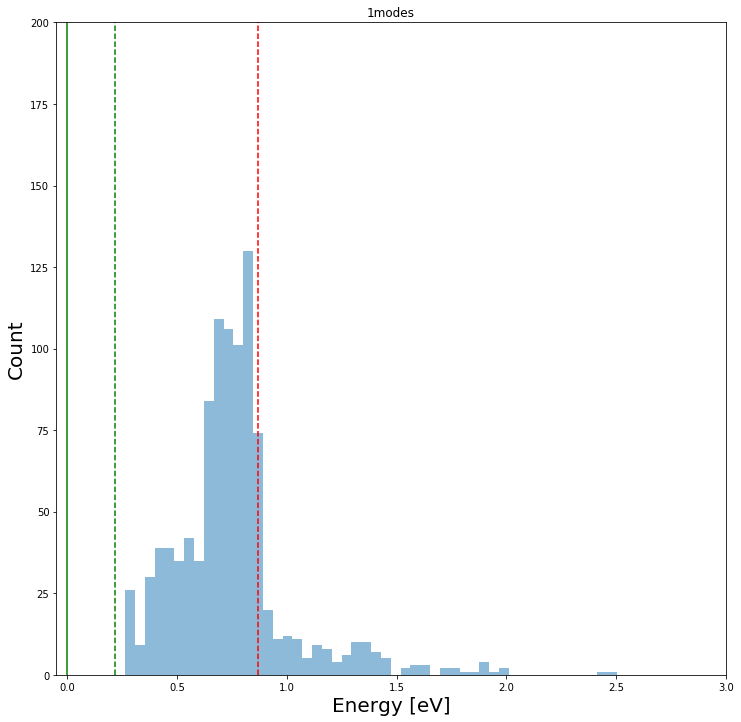

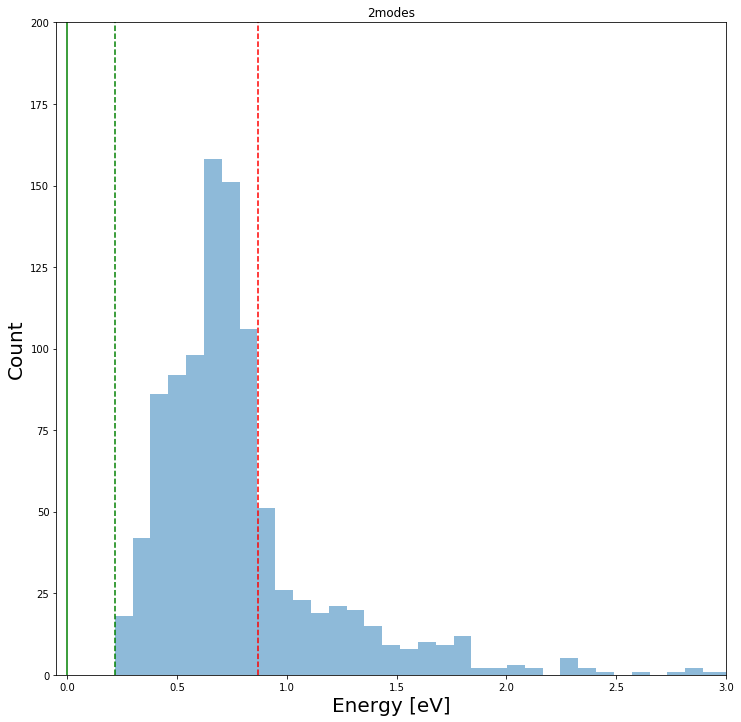

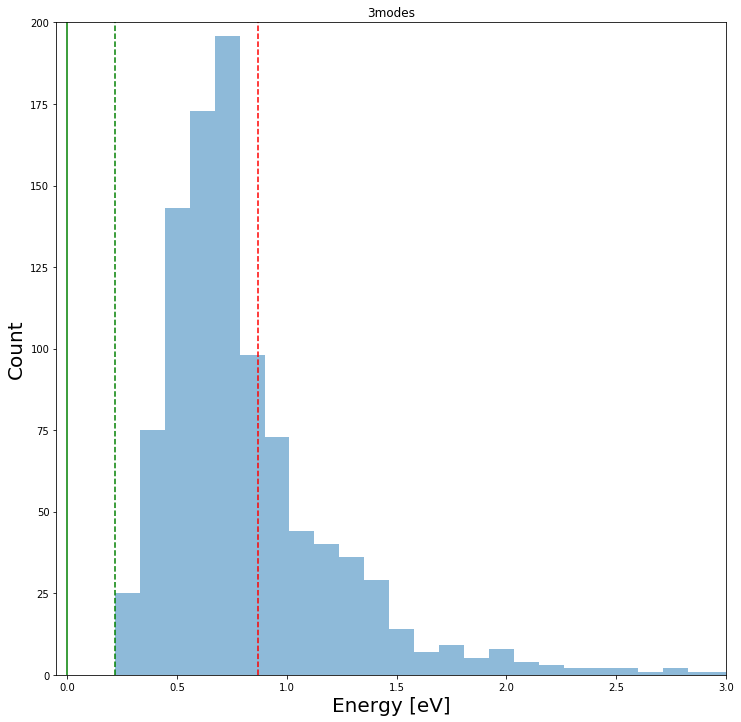

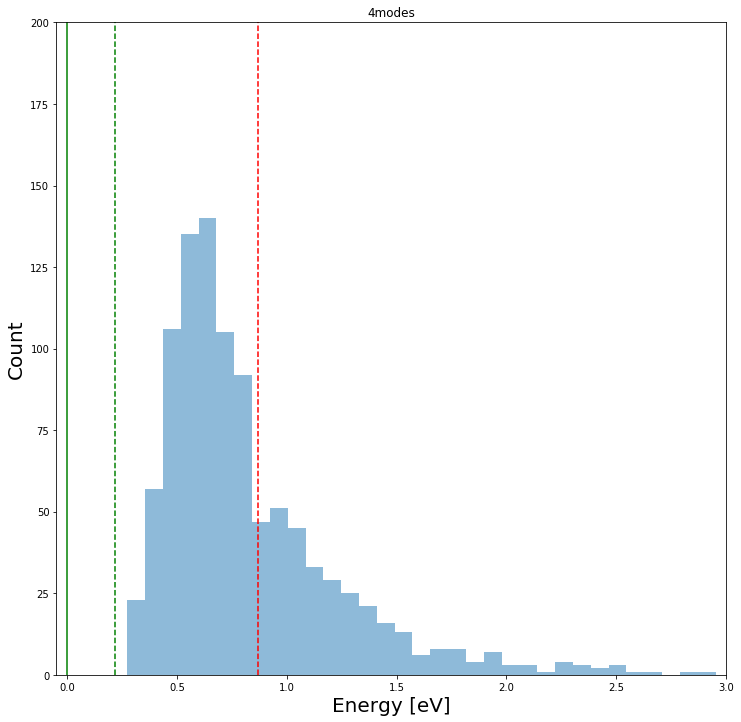

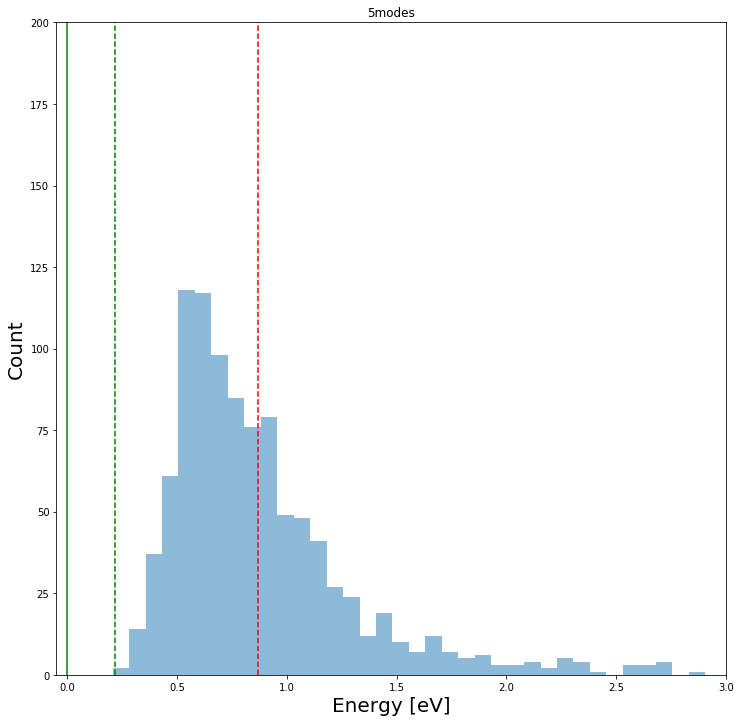

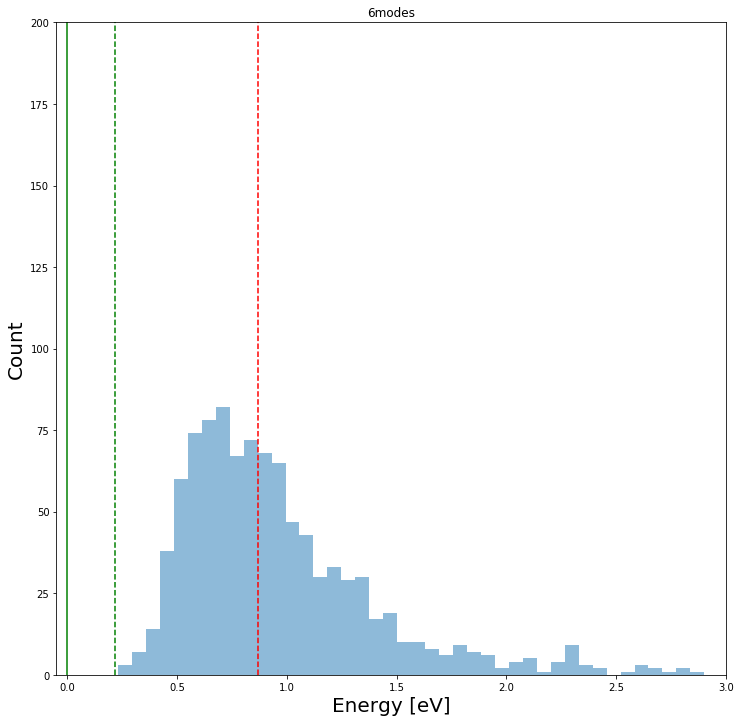

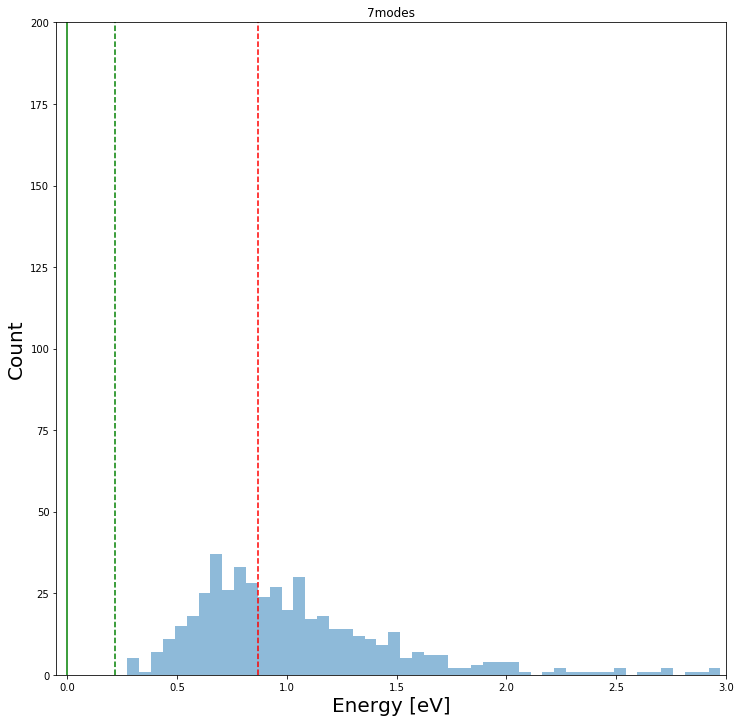

In [9]:

def plot_energies(csv_file,Nmodes,decomp=0):
    
    ref_GS = -33.55
    ref_R3c_cub = -33.334
    ref_cub = -32.68
    
    
    title_plot = str(Nmodes)+'modes'
    
    list_structures_pd = pd.read_csv(csv_file,usecols=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

    list_structures = np.array(list_structures_pd)
    list_energies = list_structures[list_structures[:,1] > -9999]
    
    print(str(Nmodes)+" modes, number of entries : ",len(list_energies), " / min of energy : ", min(list_energies[:,1])-ref_GS, " / max of energy : ", max(list_energies[:,1])-ref_GS)
    
    fig,ax = plt.subplots(figsize=(12,12))
    y = list_energies[:,1]
    plt.hist(y-ref_GS, bins=50, alpha = 0.5);
    plt.title(title_plot)
    #plt.xlim(-33.6,-30)
    plt.xlim(-0.05,3)
    plt.ylim(0,200)
    plt.axvline(x=ref_cub-ref_GS,color='r', linestyle='--')
    plt.axvline(x=ref_GS-ref_GS,color='g', linestyle='-')
    plt.axvline(x=ref_R3c_cub-ref_GS,color='g', linestyle='--')
    plt.xlabel('Energy [eV]',fontsize=20)
    plt.ylabel('Count',fontsize=20)
    
    if decomp == 1:
        
        for i in range(0,21):
            fig,ax = plt.subplots(figsize=(6,6))
            axis_font = {'fontname':'Times', 'size':'20'}
            list_mode = []
            list_mode = list_energies[abs(list_energies[:,i+3]) > 0.02]
        
            plt.plot(list_mode[:,i+3],(list_mode[:,1]-ref_GS)*1000,'.',markersize=10)

            plt.axhline(y=(ref_cub-ref_GS)*1000,color='r', linestyle='--')
            plt.axhline(y=(ref_GS-ref_GS)*1000,color='g', linestyle='-.')
            plt.axhline(y=(ref_R3c_cub-ref_GS)*1000,color='g', linestyle='--')
            
            ax.yaxis.set_major_locator(plt.MaxNLocator(8))
            ax.xaxis.grid(True)
            ax.yaxis.grid(True)
            plt.xlabel('Amplitude [Å]',fontsize=20)
            plt.ylabel('Energy [eV]',fontsize=20)
            plt.title(title_plot)
            plt.xlim(-1.2,1.2)
            plt.ylim(0,1000)
            plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1)
            plt.yticks(fontsize=15)
    
    
os.chdir(rootdir)    
    
Nmodes = 1
min_bond = 1.8
    
csv_file = 'Distortion_modes_Descriptors_data/EnergyModes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
plot_energies(csv_file,Nmodes)



Nmodes = 2
min_bond = 1.8
    
csv_file = 'Distortion_modes_Descriptors_data/EnergyModes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
plot_energies(csv_file,Nmodes)



Nmodes = 3
min_bond = 1.8
    
csv_file = 'Distortion_modes_Descriptors_data/EnergyModes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
plot_energies(csv_file,Nmodes)



Nmodes = 4
min_bond = 1.8
    
csv_file = 'Distortion_modes_Descriptors_data/EnergyModes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
plot_energies(csv_file,Nmodes)



Nmodes = 5
min_bond = 1.8
    
csv_file = 'Distortion_modes_Descriptors_data/EnergyModes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
plot_energies(csv_file,Nmodes)



Nmodes = 6
min_bond = 1.8
    
csv_file = 'Distortion_modes_Descriptors_data/EnergyModes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
plot_energies(csv_file,Nmodes)



Nmodes = 7
min_bond = 1.8
    
csv_file = 'Distortion_modes_Descriptors_data/EnergyModes_amplitudes_Random_'+str(Nmodes)+'modes_minbond_'+str(min_bond)+'.csv'
plot_energies(csv_file,Nmodes)

